In [1]:
import os
import cv2
import torch
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Violent Detection System Using VGG19
Its a video based dataset where we have to perform these tasks for fine tuned model training
1. Read the dataset and load the dataset.
2. Spliting the dataset as Train, Validation and Testing.
3. Extract the image frames from the videos and save these Image frames as Directory in the Kaggle working directory.
4. Perform the Dataaugmentation on the Extracted frames as Fliping, Rotation and Resizing...
5. Count the total Frames extracted from videos.
6. Load the Pretrained VGG19 model.
7. First freeze all the Layers and then Unfreeze few last layers of the model as from 28 to 36.
8. If dataset is Imbalanced then set the Higher Weight to class 1 as Violent
9. Trained the Fine Tune Model.
10. Measures and shows these results as Classification report(Precision, Recall,F1-Score and Accuracy).
11. Testing on unseen Data as gradio.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

# Paste your paths
train_videos = "/kaggle/input/project-data/Complete Dataset/train/HockeyFight"
val_videos = "/kaggle/input/project-data/Complete Dataset/val/HockeyFight"

# New base dir for extracted frames
base_out_dir = "/kaggle/working/frames_split"

# Classes
classes = ['Violent', 'NonViolent']  # Your dataset must have 2 classes


In [5]:
all_videos = []

# Collect from both train and val
for class_name in classes:
    for folder in [train_videos, val_videos]:
        class_folder = os.path.join(folder, class_name)
        if os.path.exists(class_folder):
            video_files = list(Path(class_folder).glob("*.avi"))
            all_videos.extend([(str(f), class_name) for f in video_files])


In [7]:
from pathlib import Path

# Dataset root
train_dir = '/kaggle/input/project-data/Complete Dataset/train'
val_dir   = '/kaggle/input/project-data/Complete Dataset/val'

# Folder → Label mapping
folder_to_label = {
    'HockeyFight': 'Violent',
    'NonFight': 'NonViolent'  # Change this if it's named differently
}

# Collect videos with correct label
all_videos = []

for root_dir in [train_dir, val_dir]:
    for folder_name, label in folder_to_label.items():
        folder_path = Path(root_dir) / folder_name
        if folder_path.exists():
            videos = list(folder_path.glob("*.avi"))
            print(f"Found {len(videos)} videos in {folder_path} ({label})")
            all_videos.extend([(str(video), label) for video in videos])
        else:
            print(f"⚠️ Folder not found: {folder_path}")


Found 400 videos in /kaggle/input/project-data/Complete Dataset/train/HockeyFight (Violent)
Found 1000 videos in /kaggle/input/project-data/Complete Dataset/train/NonFight (NonViolent)
Found 100 videos in /kaggle/input/project-data/Complete Dataset/val/HockeyFight (Violent)
Found 275 videos in /kaggle/input/project-data/Complete Dataset/val/NonFight (NonViolent)


In [8]:
from sklearn.model_selection import train_test_split

# Split into 85% train+val, 15% test
train_val_videos, test_videos = train_test_split(
    all_videos,
    test_size=0.15,
    stratify=[label for _, label in all_videos],
    random_state=42
)

# From train+val, take 15% as validation
train_videos, val_videos = train_test_split(
    train_val_videos,
    test_size=0.1765,  # 0.1765 * 85% ≈ 15% of total
    stratify=[label for _, label in train_val_videos],
    random_state=42
)

print(f"Total: {len(all_videos)}")
print(f"Train: {len(train_videos)}, Val: {len(val_videos)}, Test: {len(test_videos)}")


Total: 1775
Train: 1241, Val: 267, Test: 267


In [10]:
import cv2

def extract_and_save_frames(video_list, split_name, frames_per_video=10):
    for video_path, label in video_list:
        output_dir = os.path.join(base_out_dir, split_name, label)
        os.makedirs(output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // frames_per_video)
        
        i = 0
        count = 0
        while cap.isOpened() and count < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            if i % step == 0:
                filename = f"{Path(video_path).stem}_frame{count}.jpg"
                frame_path = os.path.join(output_dir, filename)
                cv2.imwrite(frame_path, frame)
                count += 1
            i += 1
        cap.release()


In [13]:
extract_and_save_frames(train_videos, 'train')
extract_and_save_frames(val_videos, 'val')
extract_and_save_frames(test_videos, 'test')


In [15]:
from torchvision.transforms import RandomAffine

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        RandomAffine(degrees=0, shear=10, translate=(0.1, 0.1)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [17]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder('/kaggle/working/frames_split/train', transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder('/kaggle/working/frames_split/val', transform=data_transforms['val'])
test_dataset  = datasets.ImageFolder('/kaggle/working/frames_split/test', transform=data_transforms['val'])  # use same as val

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [18]:
import os

def count_frames(root_dir):
    total = 0
    print(f"\nCounting frames in: {root_dir}")
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            print(f"{split} directory not found.")
            continue
        
        split_total = 0
        print(f"\n📁 {split.upper()}:")

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                split_total += num_images
                print(f"  - {class_name}: {num_images} frames")

        print(f"🔢 Total {split} frames: {split_total}")
        total += split_total

    print(f"\n✅ Overall total frames: {total}")

# Run the function
count_frames('/kaggle/working/frames_split')



Counting frames in: /kaggle/working/frames_split

📁 TRAIN:
  - NonViolent: 8910 frames
  - Violent: 3500 frames
🔢 Total train frames: 12410

📁 VAL:
  - NonViolent: 1920 frames
  - Violent: 750 frames
🔢 Total val frames: 2670

📁 TEST:
  - NonViolent: 1920 frames
  - Violent: 750 frames
🔢 Total test frames: 2670

✅ Overall total frames: 17750


In [20]:
from torchvision import models
import torch.nn as nn

# Load pretrained VGG19
vgg19 = models.vgg19(pretrained=True)

# === Step 1: Freeze all layers ===
for param in vgg19.parameters():
    param.requires_grad = False

# We'll unfreeze the last 2 convolutional blocks (layers 28 to 36 in VGG19 features)
for i in range(28, len(vgg19.features)):
    for param in vgg19.features[i].parameters():
        param.requires_grad = True

# === Step 3: Modify classifier for binary classification ===
vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Send model to device (GPU or CPU)
vgg19 = vgg19.to(device)


In [22]:
# Assign higher weight to class 1 (Violent) if imbalanced
class_weights = torch.tensor([1.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(vgg19.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [24]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, dataloader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [25]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(vgg19, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(vgg19, val_loader, criterion)

    print(f"✅ Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

    scheduler.step()



📘 Epoch 1/5


✅ Train Loss: 0.1073 | Accuracy: 0.9612
🧪 Val   Loss: 0.1063 | Accuracy: 0.9678

📘 Epoch 2/5


✅ Train Loss: 0.0393 | Accuracy: 0.9877
🧪 Val   Loss: 0.0540 | Accuracy: 0.9809

📘 Epoch 3/5


✅ Train Loss: 0.0248 | Accuracy: 0.9924
🧪 Val   Loss: 0.0600 | Accuracy: 0.9783

📘 Epoch 4/5


✅ Train Loss: 0.0154 | Accuracy: 0.9943
🧪 Val   Loss: 0.0397 | Accuracy: 0.9910

📘 Epoch 5/5


✅ Train Loss: 0.0143 | Accuracy: 0.9959
🧪 Val   Loss: 0.0494 | Accuracy: 0.9873


In [26]:
test_loss, test_acc = validate(vgg19, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")



🎯 Final Test Accuracy: 0.9813


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import numpy as np


In [28]:
vgg19.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = vgg19(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1 (Violent)


In [30]:
from sklearn.metrics import classification_report

# Generate the report
report = classification_report(all_labels, all_preds, target_names=['NonViolent', 'Violent'])

# Print it
print("📊 Classification Report:\n")
print(report)

# Save it to a file
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write("📊 Classification Report:\n\n")
    f.write(report)

print("✅ Saved classification_report.txt in /kaggle/working/")


📊 Classification Report:

              precision    recall  f1-score   support

  NonViolent       0.98      1.00      0.99      1920
     Violent       0.99      0.94      0.97       750

    accuracy                           0.98      2670
   macro avg       0.99      0.97      0.98      2670
weighted avg       0.98      0.98      0.98      2670

✅ Saved classification_report.txt in /kaggle/working/


/tmp/ipykernel_35/1371876415.py:18: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.savefig('/kaggle/working/confusion_matrix.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


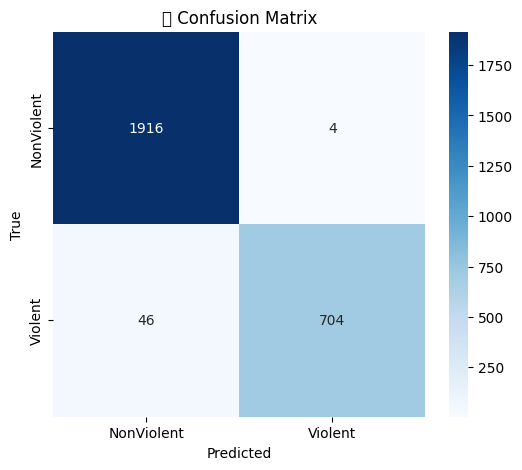

✅ Confusion matrix saved to /kaggle/working/confusion_matrix.png


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NonViolent', 'Violent'],
            yticklabels=['NonViolent', 'Violent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('🧩 Confusion Matrix')

# Save to Kaggle working directory
plt.savefig('/kaggle/working/confusion_matrix.png')

# Also show inline (for Kaggle notebook users)
plt.show()

print("✅ Confusion matrix saved to /kaggle/working/confusion_matrix.png")


/tmp/ipykernel_35/1431665227.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig('/kaggle/working/roc_curve.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


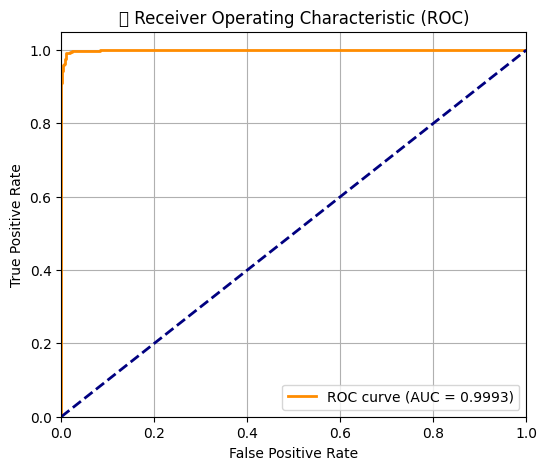

✅ ROC curve saved to /kaggle/working/roc_curve.png


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

# Save to working directory
plt.savefig('/kaggle/working/roc_curve.png')

# Show inline (for notebooks)
plt.show()

print("✅ ROC curve saved to /kaggle/working/roc_curve.png")


In [33]:
model_path = "/kaggle/working/vgg19_finetuned_violence.pth"
torch.save(vgg19.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")


✅ Model saved to /kaggle/working/vgg19_finetuned_violence.pth


In [ ]:
from torchvision import models
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load base model
vgg19 = models.vgg19(pretrained=False)  # No need to load pretrained weights again
vgg19.classifier[6] = nn.Linear(4096, 2)  # Match your fine-tuned classifier
vgg19.load_state_dict(torch.load("/kaggle/working/vgg19_finetuned_violence.pth", map_location=device))
vgg19 = vgg19.to(device)
vgg19.eval()


In [1]:
!pip install gradio opencv-python --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 33.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 104.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00


In [2]:
import gradio as gr
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import cv2
import os
import shutil

# ======== Load Model ========
model = models.vgg19(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load("/kaggle/input/vgg19-fine-tuned/keras/default/1/vgg19_finetuned_violence.pth", map_location='cpu'))
model.eval()

class_names = ['NonViolent', 'Violent']

# ======== Transform (for prediction) ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Function to Annotate Video Live ========
def annotate_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("❌ Could not open video file.")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    output_path = "/kaggle/working/annotated_video.avi"
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to PIL and apply transform
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_img).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, 1).item()
            label = class_names[pred]
            confidence = torch.softmax(output, dim=1)[0][pred].item()

        # Annotate the frame
        color = (0, 0, 255) if label == "Violent" else (0, 255, 0)
        tag = f"{label.upper()} ({confidence:.2f})"
        cv2.putText(frame, tag, (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()

    return output_path

# ======== Gradio Interface Function ========
def run_annotated_video(video):
    try:
        annotated_video_path = annotate_video(video)
        return annotated_video_path
    except Exception as e:
        print(f"❌ ERROR: {e}")
        return None

# ======== Gradio App ========
iface = gr.Interface(
    fn=run_annotated_video,
    inputs=gr.Video(label="Upload Video"),
    outputs=gr.Video(label="Annotated Output"),
    title="🎥 Real-Time Violence Detection",
    description="This app runs frame-by-frame violence detection and displays annotated output video."
)

iface.launch(debug=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1ccadd51f3028f283d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/gradio/components/video.py:355: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/components/video.py:355: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1ccadd51f3028f283d.gradio.live
